In [1]:
from time import time
import hydra
from omegaconf import DictConfig, OmegaConf
import numpy as np
import torch
import pypolo
import gpytorch
from pypolo.scalers import MinMaxScaler, StandardScaler
import yaml
from PIL import Image



In [2]:

def set_random_seed(seed):
    rng = np.random.RandomState(seed)
    torch.manual_seed(seed)
    print(f"Set random seed to {seed} in numpy and torch.")
    return rng


def get_environment(cfg, filepath="./data/n44w111.npz"):
    with np.load(filepath) as data:
        env = data["arr_0"]
    print(f"Loaded environment of shape {env.shape}.")
    return env


def get_environment_from_image(cfg, png_path, resize=None, max_height=None):
    
    image = Image.open(png_path)

    if resize is not None:
        if not isinstance(resize, tuple):
            raise TypeError
        else:
            resized_image = image.resize(resize, Image.BOX)
            image = resized_image.convert('L') 
    
    env = np.array(image)
    
    if max_height is not None:
        
        if not isinstance(max_height, float):
            raise TypeError
        else:
            min_value = np.min(env)
            max_value = np.max(env)
            normalized_matrix = (env - min_value) / (max_value - min_value)
            env = normalized_matrix * max_height
            
    print(f"Loaded environment of shape {env.shape}.")
    return env


def get_sensor(cfg, env, rng):
    
    sensor = pypolo.sensors.LidarSensor(
        matrix=env,
        env_extent=cfg.env_extent,
        rate=cfg.sensing_rate,
        noise_scale=cfg.noise_scale,
        rng=rng,
        max_distance = 2,
        perception_angle=90,
    )
    
    print(
        f"Initialized sensor with rate {cfg.sensing_rate} and noise scale {cfg.noise_scale}."
    )
    return sensor


def get_robot(cfg, sensor, robot_start):
    
    robot = pypolo.robots.DigitRobot(
        sensor=sensor,
        state=robot_start,
        control_rate=cfg.control_rate,
        max_lin_vel=cfg.max_lin_vel,
        max_ang_vel=cfg.max_ang_vel,
        goal_radius=cfg.goal_radius,
    )
    
    # robot = pypolo.robots.DiffDriveRobot(
    #     sensor=sensor,
    #     state=np.array([cfg.task_extent[1], cfg.task_extent[2], -np.pi]),
    #     control_rate=cfg.control_rate,
    #     max_lin_vel=cfg.max_lin_vel,
    #     max_ang_vel=cfg.max_ang_vel,
    #     goal_radius=cfg.goal_radius,
    # )
    print(f"Initialized robot with control rate {cfg.control_rate}.")
    return robot


def get_visualizer(cfg, env):
    visualizer = pypolo.utils.Visualizer(
        cfg.env_extent, cfg.task_extent, cfg.plot_robot_interval
    )
    vmin, vmax = np.min(env), np.max(env)
    visualizer.vmins[1], visualizer.vmaxs[1] = vmin, vmax
    visualizer.plot_image(
        index=0, matrix=env, title="Ground Truth", vmin=vmin, vmax=vmax
    )
    print(f"Initialized visualizer.")
    return visualizer


def pilot_survey(cfg, robot, rng):
    
    # Use DiffDriveRobot to survey around the terrain
    
    # bezier_planner = pypolo.planners.BezierPlanner(cfg.task_extent, rng)
    # goals = bezier_planner.plan(num_points=cfg.num_bezier_points)
    # robot.goals = goals
    
    # while len(robot.goals) > 0:
    #     robot.step_with_heading(current_heading=robot.state[2], num_targets = 3)
    #     # heading_c = np.arctan2(robot.state[1] - prev_state[1], robot.state[0] - prev_state[0])
    #     # prev_state = robot.state[:2]
        
    # x_init, y_init = robot.commit_samples()
    
    #-------------------------------------------------------------------
    
    #Randomly Sample
    x_min, x_max, y_min, y_max = cfg.task_extent
    x_grid = np.linspace(x_min, x_max, 10)
    y_grid = np.linspace(y_min, y_max, 10)
    xx, yy = np.meshgrid(x_grid, y_grid)
    x_init = np.column_stack((xx.flatten(), yy.flatten()))
    y_init = robot.sensor.get(x_init[:, 0], x_init[:, 1]).reshape(-1, 1)
    
    #-------------------------------------------------------------------
    
    print(f"Collected {len(x_init)} samples in pilot survey.")

    return x_init, y_init


def get_model(cfg, x_init, y_init, x_scaler, y_scaler):
    if cfg.kernel.name == "RBF":
        kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        kernel.base_kernel.lengthscale = cfg.kernel.lengthscale
        kernel.outputscale = cfg.kernel.outputscale
    elif cfg.kernel.name == "AK":
        kernel = gpytorch.kernels.ScaleKernel(
            pypolo.models.gp.kernels.AttentiveKernel(
                dim_input=x_init.shape[1],
                dim_hidden=cfg.kernel.dim_hidden,
                dim_output=cfg.kernel.dim_output,
                min_lengthscale=cfg.kernel.min_lengthscale,
                max_lengthscale=cfg.kernel.max_lengthscale,
            )
        )
    else:
        raise ValueError(f"Unknown kernel: {cfg.kernel}")
    if cfg.model.name == "GPR":
        model = pypolo.models.gp.GPRModel(
            x_train=x_init,
            y_train=y_init,
            x_scalar=x_scaler,
            y_scalar=y_scaler,
            kernel=kernel,
            noise_var=cfg.model.noise_var,
            num_sparsification=cfg.model.num_sparsification,
        )
    else:
        raise ValueError(f"Unknown model: {cfg.model.name}")
    print(f"Initialized model {cfg.model.name} with kernel {cfg.kernel.name}.")
    return model


def get_planner(cfg, rng, robot, goal=None, obstacles=None):
    if cfg.planner.name == "MaxEntropy":
        planner = pypolo.planners.MaxEntropyPlanner(
            cfg.task_extent, rng, cfg.planner.num_candidates
        )
    elif cfg.planner.name == "AStar":
        
        start = robot.state[:2]
        planner = pypolo.planners.AStarPlanner(
            cfg.task_extent, rng, start, goal, obstacles
        )
        
    else:
        raise ValueError(f"Unknown planner: {cfg.planner.name}")
    print(f"Initialized planner {cfg.planner.name}.")
    return planner


def model_update(num_steps, model, evaluator):
    # print("Optimization...")
    start = time()
    losses = model.optimize(num_steps=num_steps) #calculate lossses
    end = time()
    evaluator.training_times.append(end - start)
    evaluator.losses.extend(losses)


def evaluation(model, evaluator):
    # print(f"Prediction...")
    start = time()
    mean, std = model.predict(evaluator.eval_inputs)
    end = time()
    evaluator.prediction_times.append(end - start)
    evaluator.compute_metrics(mean, std)


def visualization(visualizer, evaluator, x_inducing=None):
    # print(f"Visualization...")
    visualizer.plot_prediction(evaluator.mean, evaluator.std, evaluator.abs_error)
    visualizer.plot_data(evaluator.x_train)
    if x_inducing is not None:
        print("Plotting inducing inputs...")
        visualizer.plot_inducing_inputs(x_inducing)
    visualizer.plot_metrics(evaluator)


def information_gathering(model, robot, planner, num_step=1, samples_per_dt=10, visualizer=None):
    
    print("Run information_gathering")
    
    final_goal = planner.goal
    
    while True:

        goal = planner.get_next_goal(robot, num_step)
        print("goal:", goal)
        # print("path", planner.path)
        # print("current", (robot.wp_c_x, robot.wp_c_y))
    
        visualizer.plot_goal(goal, final_goal)
        robot.goals = goal
        
        # print("Desired goal from planner.plan(): " ,robot.goals)
        
        visualizer.pause()
        plot_counter = 0
        
        print("Sampling...")
        while robot.has_goals:
            
            print("state: " ,robot.state)
            plot_counter += 1
            
            # robot.step()
            
            robot.step(model, num_targets = samples_per_dt)
                        
            if visualizer.interval > 0 and plot_counter % visualizer.interval == 0:
                visualizer.plot_robot(robot.state)
                visualizer.pause()
        if len(robot.sampled_observations) > 0:
            # print("Append Sample Elevation: ", robot.sampled_observations)
            # print("corresponding Sample Location: ", robot.sampled_locations)
            x_new, y_new = robot.commit_samples()
            print("End information_gathering")
            return x_new, y_new

In [3]:
class Struct(object):
    def __init__(self, d):
        for k, v in d.items():
            
            k = k.replace("-","_")
            
            #Setting default configuration
            if k == 'defaults':
                parsed_list = eval(str(v))
                
                for item in parsed_list:
                    if isinstance(item, dict):
                        for key, value in item.items():
                            if key == '_self_':
                                pass
                            elif key == 'model':
                                with open('./configs/' + str(key) + '/' + str(value) + '.yaml') as info:
                                    args = yaml.load(info)
                                    sub_cfg = Struct(args)
                                
                                setattr(self, key.replace("/", "_").replace(" ","_"), sub_cfg)
                                
                            elif key == 'planner':
                                with open('./configs/' + str(key) + '/' + str(value) + '.yaml') as info:
                                    args = yaml.load(info)
                                    sub_cfg = Struct(args)
                                
                                setattr(self, key.replace("/", "_").replace(" ","_"), sub_cfg)
                                
                            elif key == 'kernel':
                                with open('./configs/' + str(key) + '/' + str(value) + '.yaml') as info:
                                    args = yaml.load(info)
                                    sub_cfg = Struct(args)
                                
                                setattr(self, key.replace("/", "_").replace(" ","_"), sub_cfg)
                                
                            else:
                                setattr(self, key.replace("/", "_").replace(" ","_"), Struct(value) if isinstance(value, dict) else value)
                            
            else:
                
                #Add other struct argument
                if isinstance(k, (list, tuple)):
                    setattr(self, k, [Struct(x) if isinstance(x, dict) else x for x in v])
                else:
                    setattr(self, k, Struct(v) if isinstance(v, dict) else v)
                
            
                

with open('./configs/main.yaml') as info:
    args = yaml.load(info)
    
print(args)
cfg = Struct(args)

{'seed': 0, 'env_extent': [-11.0, 11.0, -11.0, 11.0], 'task_extent': [-10.0, 10.0, -10.0, 10.0], 'eval_grid': [30, 30], 'sensing_rate': 0.5, 'noise_scale': 1.0, 'control_rate': 10.0, 'max_lin_vel': 0.5, 'max_ang_vel': 1.0, 'goal_radius': 0.1, 'num_bezier_points': 50, 'num_train_steps': 10, 'max_num_samples': 800, 'plot_robot_interval': 10, 'defaults': [{'model': 'gpr'}, {'kernel': 'ak'}, {'planner': 'max_entropy'}, {'override hydra/hydra_logging': 'disabled'}, {'override hydra/job_logging': 'disabled'}, '_self_'], 'hydra': {'output_subdir': None, 'run': {'dir': '.'}}}


In [4]:
env_path = '/home/kmuenpra/Desktop/terrains/terrain_n38_w087_1arc_v2.png'

rng = set_random_seed(cfg.seed)
max_height = 0.3
env = get_environment_from_image(cfg, png_path=env_path, resize=(50,50), max_height=max_height)


Set random seed to 0 in numpy and torch.
Loaded environment of shape (50, 50).


In [5]:
#Update few configurations

cfg.noise_scale = 0.1 * max_height
cfg.planner.name = "AStar"

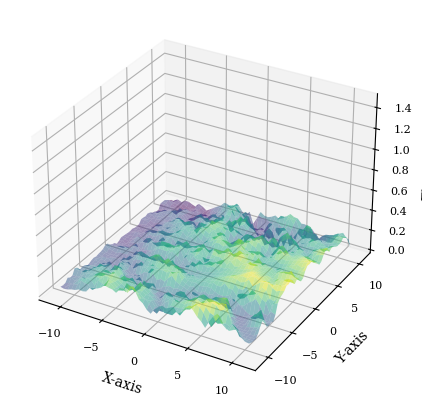

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
    

# # Create a meshgrid for X and Y coordinates
xi = np.linspace(cfg.env_extent[0] , cfg.env_extent[1], env.shape[0])
yi = np.linspace(cfg.env_extent[2], cfg.env_extent[3], env.shape[1])
X, Y = np.meshgrid(xi, yi)

# Create a 3D plot
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')

# Plot the interpolated surface
# ax.plot_surface(xnew, ynew, znew, cmap='viridis', alpha=0.5, label='Interpolated Surface')
ax.plot_surface(X,Y,env,cmap='viridis', alpha=0.5)

# Set labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Elevation')
ax.set_zlim([0, 1.5])

plt.show()

Initialized visualizer.


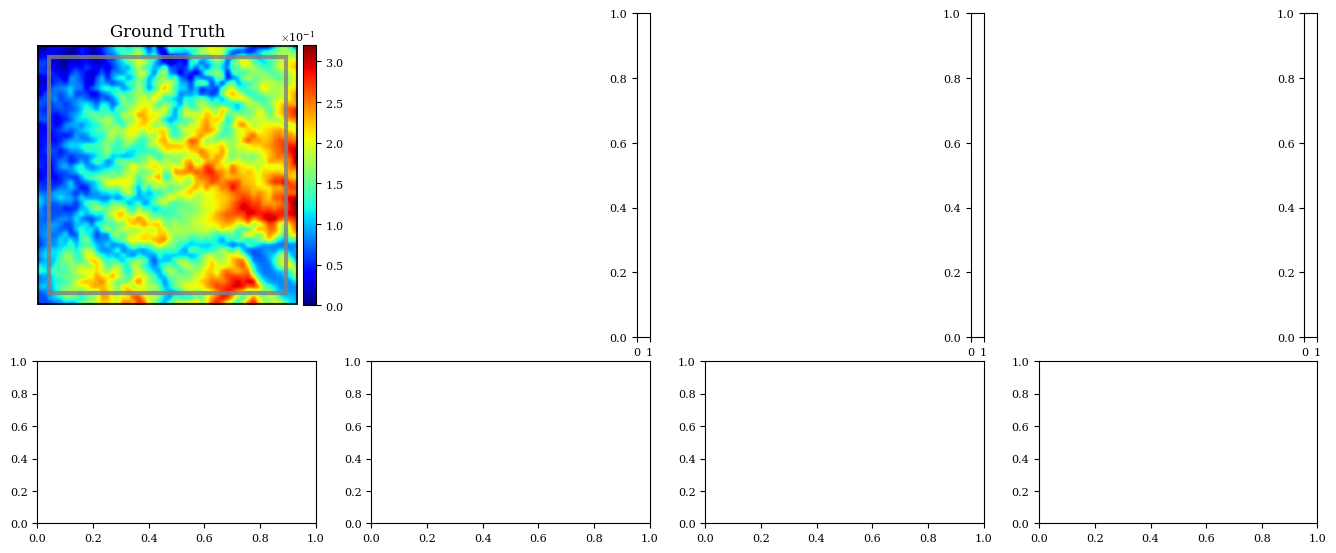

In [7]:
visualizer = get_visualizer(cfg, env)

In [8]:
#Setup sensors with noise, and set the environement coordinate to the env_extent
sensor =  get_sensor(cfg, env, rng)
sensor.matrix

Initialized sensor with rate 0.5 and noise scale 0.032.


array([[0.06990291, 0.06058252, 0.06679612, ..., 0.14291262, 0.11184466,
        0.10718447],
       [0.06368932, 0.06213592, 0.09786408, ..., 0.10407767, 0.10563107,
        0.09320388],
       [0.06679612, 0.0792233 , 0.0792233 , ..., 0.09009709, 0.09009709,
        0.08854369],
       ...,
       [0.04038835, 0.04349515, 0.03106796, ..., 0.18174757, 0.18174757,
        0.18640777],
       [0.01708738, 0.01864078, 0.04504854, ..., 0.17553398, 0.17087379,
        0.15223301],
       [0.00466019, 0.        , 0.02796117, ..., 0.17864078, 0.13203883,
        0.06058252]])

In [9]:
#Evaluator for calculate and keep track of SMSES, RMSES, MAES, MSLLS, NLPDS (refer to the Paper)

evaluator = pypolo.utils.Evaluator(sensor, cfg.task_extent, cfg.eval_grid)

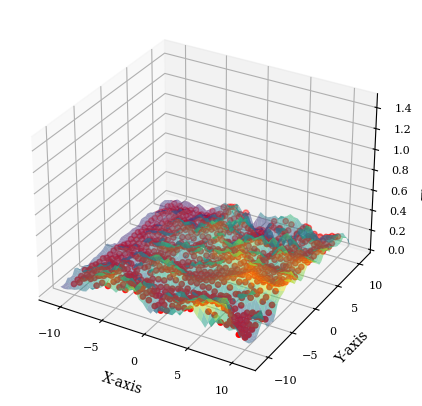

In [10]:
# Create a 3D plot for evaluatinf points
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X,Y,env,cmap='viridis', alpha=0.5)
ax.scatter(evaluator.eval_inputs[:,0],evaluator.eval_inputs[:,1],evaluator.eval_outputs,color='red', s=15)

# Set labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Elevation')
ax.set_zlim([0, 1.5])

plt.show()

In [11]:
evaluator.eval_inputs.shape

(900, 2)

In [12]:
# Global Planner

start = np.array([-10,-10])
global_goal = np.array([5,5])
obstacles = np.array([])

global_planner = pypolo.planners.AStarPlanner(
            cfg.task_extent, rng, start, global_goal, obstacles, step_l_max=1, step_l_min=0.9
            )

global_planner.plan()

Planning path...
Reach the goal!


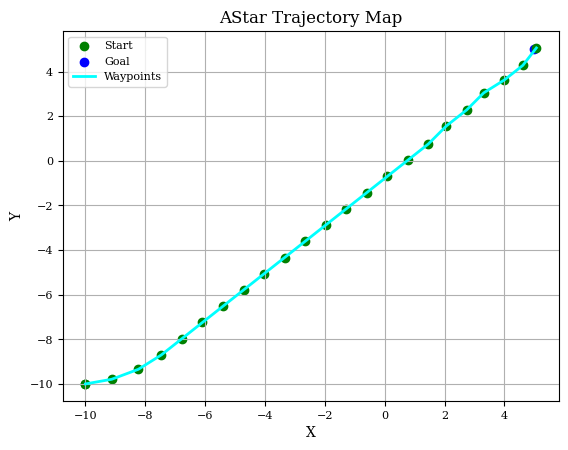

In [13]:
global_planner.plot_map()

In [14]:
localGP_info = {"center":[],
                "bound_x":[],
                "bound_y":[],
             "local_goal": [],
             "local_data":[]}


# initialize clusters' centerpoints
# NOTE number of clusters = num_grid_x * num_grid_y
num_grid_x = 3
num_grid_y = 3

k = num_grid_x * num_grid_y #initilize number of clusters
all_center_point = []

xi = np.linspace(cfg.env_extent[0] , cfg.env_extent[1], num_grid_x + 1).astype(int)
yi = np.linspace(cfg.env_extent[2] , cfg.env_extent[3], num_grid_x + 1).astype(int)

#Overlap-ness of the subgrids (defined in percentage)
overlap = 0

for i in  range(len(xi) - 1):
    for j in range(len(yi) - 1):
        
        # Set the bounds for each dimension
        bounds_x = (  xi[i] * (1-overlap)   ,  min(xi[i + 1] * (1+overlap), cfg.env_extent[1] ) )
        bounds_y = (  yi[j] * (1-overlap)   ,  min(yi[j + 1] * (1+overlap), cfg.env_extent[3] ))
        
        # print("x", bounds_x)
        # print("y", bounds_y)     
        
        #Find center point of the grid
        midpoint_x = (bounds_x[0] + bounds_x[1]) / 2
        midpoint_y = (bounds_y[0] + bounds_y[1]) / 2
        
        # print(midpoint_x)
        # print(midpoint_y)
        localGP_info["bound_x"].append(bounds_x)
        localGP_info["bound_y"].append(bounds_y)
        localGP_info["center"].append(np.atleast_2d([midpoint_x, midpoint_y]))
        all_center_point.append([midpoint_x, midpoint_y])
        


In [15]:
def locate_state(localGP_info, state):
    
    state = np.atleast_2d(state)
    
    for index in range(len(localGP_info["bound_x"])):
        lb_x = localGP_info["bound_x"][index][0]
        ub_x = localGP_info["bound_x"][index][1]
        lb_y = localGP_info["bound_y"][index][0]
        ub_y = localGP_info["bound_y"][index][1]
        
        if (state[:,0] >= lb_x and state[:,0] <= ub_x) and (state[:,1] >= lb_y and state[:,1] <= ub_y):\
            return index
    

for _ in range(len(localGP_info["center"])):
    localGP_info["local_data"].append(np.array([]))
    localGP_info["local_goal"].append(np.array([]))

#Assgin global waypoint to the different subgrid
for subgoal in global_planner.path:

    index = locate_state(localGP_info, subgoal)
    
    if localGP_info["local_goal"][index].shape[0] == 0:
        localGP_info["local_goal"][index] = np.atleast_2d(subgoal)
    else:
        localGP_info["local_goal"][index] = np.vstack([localGP_info["local_goal"][index] , np.atleast_2d(subgoal)])
                
#Only keep the subgoal closest to the global goal
for i in range(len(localGP_info["local_goal"])):
    if localGP_info["local_goal"][i].shape[0] == 0:
        continue
    distances = np.linalg.norm(localGP_info["local_goal"][i] - global_goal, axis=1)
    min_distance_index = np.argmin(distances)
    localGP_info["local_goal"][i] = localGP_info["local_goal"][i][min_distance_index]
    
# all_subgoals = np.array([ subgoal for eachgrid in localGP_info["local_goal"] for subgoal in eachgrid ]).reshape(-1,2)


In [16]:
localGP_info

{'center': [array([[-7., -7.]]),
  array([[-7.,  0.]]),
  array([[-7.,  7.]]),
  array([[ 0., -7.]]),
  array([[0., 0.]]),
  array([[0., 7.]]),
  array([[ 7., -7.]]),
  array([[7., 0.]]),
  array([[7., 7.]])],
 'bound_x': [(-11, -3),
  (-11, -3),
  (-11, -3),
  (-3, 3),
  (-3, 3),
  (-3, 3),
  (3, 11),
  (3, 11),
  (3, 11)],
 'bound_y': [(-11, -3),
  (-3, 3),
  (3, 11),
  (-11, -3),
  (-3, 3),
  (3, 11),
  (-11, -3),
  (-3, 3),
  (3, 11)],
 'local_goal': [array([-3.34713271, -4.33661708]),
  array([], dtype=float64),
  array([], dtype=float64),
  array([-2.66089107, -3.60924344]),
  array([2.73995899, 2.28449525]),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([5.06431712, 5.05908027])],
 'local_data': [array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=f

In [17]:
#Local Planner that robot tracks

robot_start = np.array([-10,-10,0])
robot =  get_robot(cfg, sensor, robot_start)

loc_ind = locate_state(localGP_info, robot.state[:2])
goal = np.atleast_1d(localGP_info["local_goal"][loc_ind])
print(goal)

obstacles = np.array([])
planner =  get_planner(cfg, rng, robot, goal=goal, obstacles=obstacles)

#Generate a trajectory toward goal
planner.plan(robot)

#Only works for Astart planner for now
robot.track_planner(planner)

#Update State
vapex = 0.15
robot.hard_update_state(vapex=vapex)

Initialized robot with control rate 10.0.
[-3.34713271 -4.33661708]
Initialized planner AStar.
Planning path...
Reach the goal!


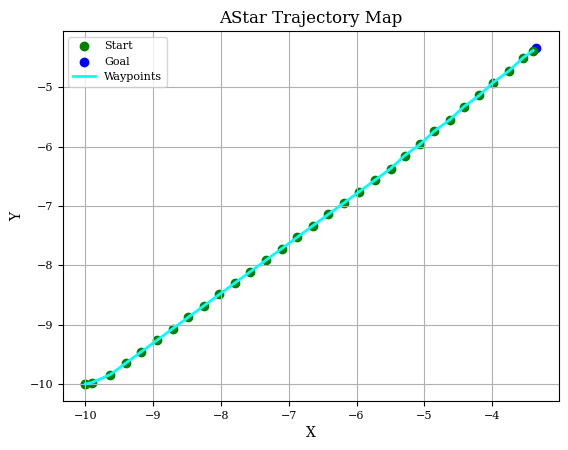

In [18]:
planner.plot_map()

In [19]:
x_init, y_init =  pilot_survey(cfg, robot, rng)


x_scaler = MinMaxScaler()
x_scaler.fit(x_init) #find min/max of (x1,x2) coordinates
y_scaler = StandardScaler()
y_scaler.fit(y_init) #find mean and std of y_init
evaluator.add_data(x_init, y_init) #set training data
print("num_samples", evaluator.num_samples)
print("training_times", evaluator.training_times)


# #Add untraversable terrain to planner map
# risk_index = np.where(y_init > max_z_digit)[0]    

# #Replan
# if not risk_index.shape[0] == 0:
#     print("New risk region found")
    
#     planner.add_obstacle(x_init[risk_index])
#     planner.plan(robot)
#     robot.track_planner(planner)
            

Collected 100 samples in pilot survey.
num_samples []
training_times []


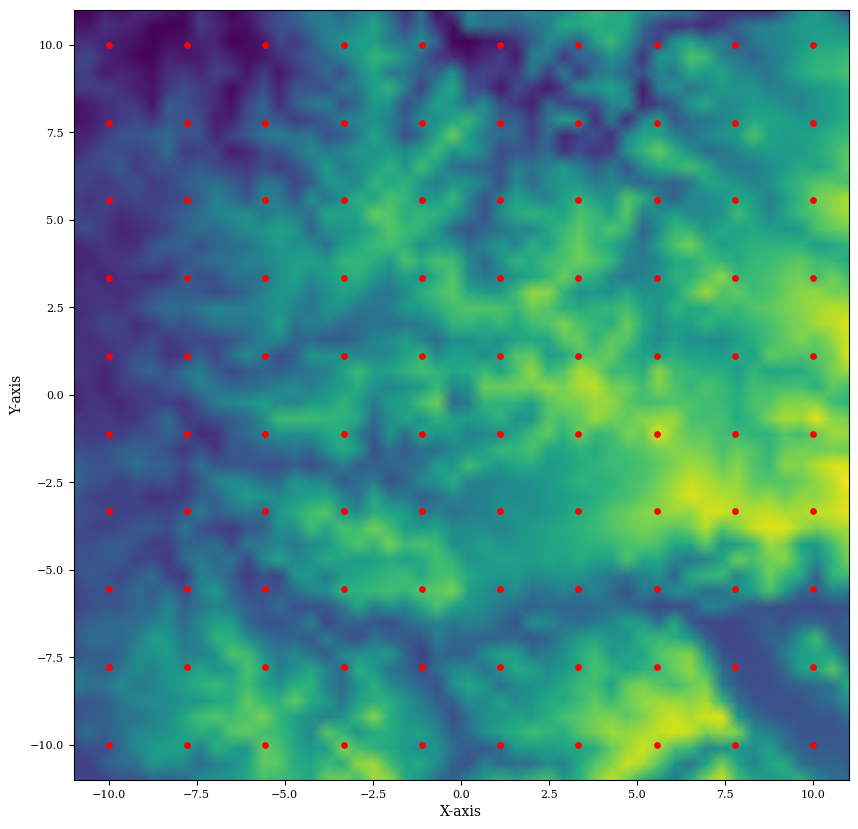

In [20]:
fig = plt.figure(figsize=(10, 10))

# Create a 3D plot
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(X,Y,env,cmap='viridis', alpha=0.5)
# ax.scatter(x_init[:,0],x_init[:,1],y_init*y_scaler.actual_std[0] +y_scaler.actual_mean[0] ,color='red', s=15)
# ax.set_xlabel('X-axis')
# ax.set_ylabel('Y-axis')
# ax.set_zlabel('Elevation')
# ax.set_zlim([0, 1.5])

#2D representation
ax = fig.add_subplot(111)
ax.pcolormesh(X,Y,env,cmap='viridis', shading='gouraud')
ax.scatter(x_init[:,0],x_init[:,1] ,color='red', s=15)
# Set labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

plt.show()

In [21]:
model = get_model(cfg, x_init, y_init, x_scaler, y_scaler)

Model parameters:
Fast lr: 0.01 likelihood.noise_covar.raw_noise torch.Size([1])
Fast lr: 0.01 covar_module.raw_outputscale torch.Size([])
Slow lr: 0.001 covar_module.base_kernel.nn.0.weight torch.Size([10, 2])
Slow lr: 0.001 covar_module.base_kernel.nn.0.bias torch.Size([10])
Slow lr: 0.001 covar_module.base_kernel.nn.2.weight torch.Size([10, 10])
Slow lr: 0.001 covar_module.base_kernel.nn.2.bias torch.Size([10])
Slow lr: 0.001 covar_module.base_kernel.nn.4.weight torch.Size([10, 10])
Slow lr: 0.001 covar_module.base_kernel.nn.4.bias torch.Size([10])
Initialized model GPR with kernel AK.


In [22]:
model_update(cfg.num_train_steps, model, evaluator)
print("losses", evaluator.losses)
print("training time", evaluator.training_times)

losses [1.3379201305122612, 1.335513691826368, 1.333116765084214, 1.3307298135275158, 1.3283532930060715, 1.3259876400338828, 1.3236332695756479, 1.3212905722522919, 1.3189599112139303, 1.3166416195085173]
training time [1.5986661911010742]


In [23]:
evaluation(model, evaluator)
print("num_samples", evaluator.num_samples)
print("training_times", evaluator.training_times)

print("smses", evaluator.smses)
print("rmses", evaluator.rmses)
print("maes", evaluator.maes)
print("mslls", evaluator.mslls)
print("nlpds", evaluator.nlpds)

num_samples [100]
training_times [1.5986661911010742]
smses [0.3821621291688403]
rmses [0.04004092083076668]
maes [0.0322829846394191]
mslls [-0.2329079888908454]
nlpds [-1.5492955334963567]


In [24]:
x_at_start, y_at_start = robot.sensor.sense( robot.state, robot.heading_c, ray_tracing = True, num_targets = 30)

model.add_data(x_at_start, y_at_start)
print("training x size", model.train_x.shape)
print("training y size",model.train_y.shape)

evaluator.add_data(x_at_start, y_at_start) #set training data
model_update(cfg.num_train_steps, model, evaluator)
print("losses", evaluator.losses)
print("training time", evaluator.training_times)

evaluation(model, evaluator)
print("num_samples", evaluator.num_samples)
print("training_times", evaluator.training_times)

training x size torch.Size([130, 2])
training y size torch.Size([130])
losses [1.3379201305122612, 1.335513691826368, 1.333116765084214, 1.3307298135275158, 1.3283532930060715, 1.3259876400338828, 1.3236332695756479, 1.3212905722522919, 1.3189599112139303, 1.3166416195085173, 1.2758092281499482, 1.2736227511158924, 1.2714515434926539, 1.2692950228557414, 1.2671527380512964, 1.26502434239702, 1.2629095733880975, 1.2608082368980262, 1.2587201947067352, 1.2566453545388496]
training time [1.5986661911010742, 0.1346445083618164]
num_samples [100, 130]
training_times [1.5986661911010742, 0.1346445083618164]


In [25]:
x_new, y_new = information_gathering(model, robot, planner, num_step=6, samples_per_dt=10, visualizer=visualizer)

Run information_gathering
goal: [[-9.90269551 -9.97693841]
 [-9.63460572 -9.84229866]
 [-9.40479239 -9.64946238]
 [-9.17497905 -9.45662609]
 [-8.94516572 -9.26378981]
 [-8.71535239 -9.07095353]]


<Figure size 640x480 with 0 Axes>

Sampling...
state:  [-10 -10   0]
(-9.902695512942017, -9.976938412925756)
---------- Digit's PSP ---------
next waypoint (-9.634605720844993, -9.84229865886562)
vapex 0.1
step_l 0.2999999999999997
dtheta 26.66666666666633
dz [[-0.88683235]]
current head 0.0
current height [[1.01208068]]
state:  [-10. -10.   0.]


/home/kmuenpra/git/Lantao_Liu/elevation_mapping_with_ak/pypolo/robots/digit_robot.py:241: RuntimeWarning: divide by zero encountered in divide
  aq = (v2 - v1) / (s2 - s1)


(-9.634605720844993, -9.84229865886562)
---------- Digit's PSP ---------
next waypoint (-9.404792387909298, -9.64946237595966)
vapex 0.25
step_l 0.29999999999999993
dtheta 13.333333333333172
dz [[-0.88775154]]
current head 26.66666666666633
current height [[1.0221517]]
state:  [-9.78338741 -9.54604996  0.46542113]
(-9.404792387909298, -9.64946237595966)
---------- Digit's PSP ---------
next waypoint (-9.174979054973603, -9.4566260930537)
vapex 0.20999999999999996
step_l 0.29999999999999993
dtheta 0.0
dz [[-0.88821592]]
current head 39.9999999999995
current height [[1.03192166]]
state:  [-9.78255086 -9.19926736  0.6981317 ]
(-9.174979054973603, -9.4566260930537)
---------- Digit's PSP ---------
next waypoint (-8.945165722037908, -9.26378981014774)
vapex 0.2599999999999999
step_l 0.29999999999999993
dtheta 0.0
dz [[-0.89609201]]
current head 39.9999999999995
current height [[1.04805462]]
state:  [-9.26902797 -9.34454296  0.6981317 ]
(-8.945165722037908, -9.26378981014774)
---------- Digi

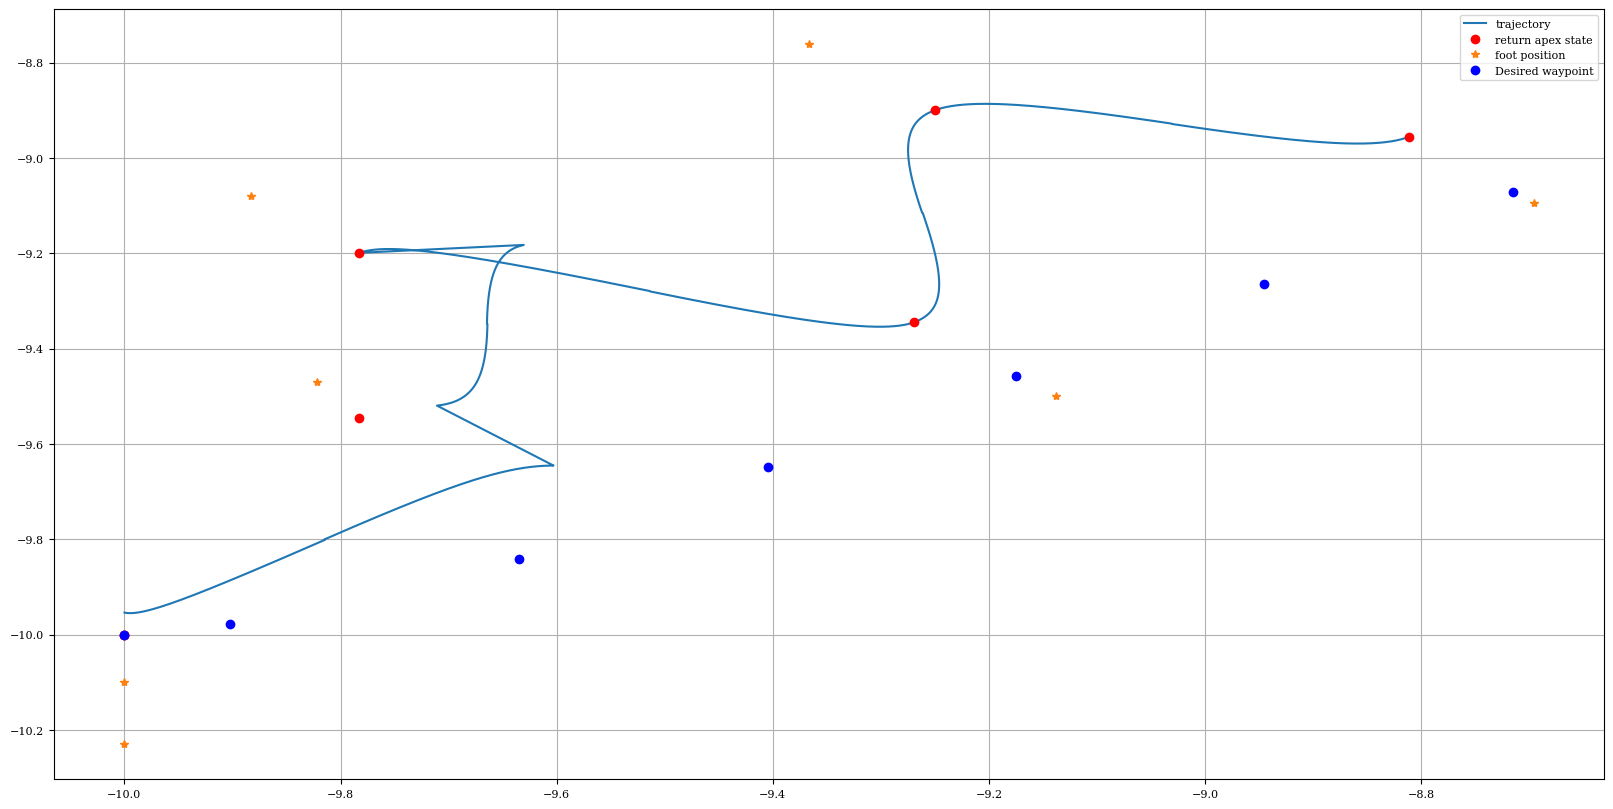

In [26]:
all_sag = np.array([])
all_lat = np.array([])
# all_wp_x = np.array([])
# all_wp_y = np.array([])


for i in range(len(robot.history["sagittal"])):
    
    sag = robot.history["sagittal"][i]
    lat = robot.history["lateral"][i]
    wp_x, wp_y, heading = robot.history["frame"][i]
    
    sag_global = np.array(sag) *np.cos(heading) - np.array(lat) *np.sin(heading) + wp_x
    lat_global = np.array(sag) *np.sin(heading) + np.array(lat) *np.cos(heading) + wp_y
    
    all_sag = np.append(all_sag,sag_global)
    all_lat = np.append(all_lat,lat_global)
    # all_wp_x = np.append(all_wp_x,wp_x)
    # all_wp_y = np.append(all_wp_y,wp_y)
    
plt.figure(figsize=(20,10))

#
plt.plot(all_sag, all_lat, label="trajectory")
plt.plot(np.array(robot.history["apex_state"])[:,0], np.array(robot.history["apex_state"])[:,1], "or", label="return apex state")
plt.plot(np.array(robot.history["foot_position"])[:,0], np.array(robot.history["foot_position"])[:,1], "*", label="foot position")
plt.plot(np.array(robot.history["waypoint_track"])[:,0], np.array(robot.history["waypoint_track"])[:,1], "bo", label="Desired waypoint")

plt.grid()
plt.legend()

In [33]:
robot.history["foot_position"]

[array([-10.     , -10.23012]),
 array([-10.     , -10.10012]),
 array([-9.82135068, -9.47045887]),
 array([-9.8827739 , -9.07982619]),
 array([-9.1382471 , -9.50040153]),
 array([-9.36651413, -8.76164633]),
 array([-8.69614416, -9.09384501])]

In [35]:
np.array(robot.history["apex_state"])

array([[-10.        , -10.        ],
       [-10.        , -10.        ],
       [ -9.78338741,  -9.54604996],
       [ -9.78255086,  -9.19926736],
       [ -9.26902797,  -9.34454296],
       [ -9.25028476,  -8.9001631 ],
       [ -8.81172164,  -8.95610512]])

In [ ]:
print("New collect sample X: ", x_new)
print("New collect observation: ", y_new)
robot.goals

In [ ]:
print("training x size", model.train_x.shape)
print("training y size",model.train_y.shape)

In [ ]:
model.add_data(x_new, y_new)
print("training x size", model.train_x.shape)
print("training y size",model.train_y.shape)

In [ ]:
model_update(cfg.num_train_steps, model, evaluator)
print("losses", evaluator.losses)
print("training time", evaluator.training_times)

In [ ]:
#scale back to actual elevation value
y_scaler.postprocess_mean(model.train_y)

In [ ]:
evaluation(model, evaluator)

print("smses", evaluator.smses)
print("rmses", evaluator.rmses)
print("maes", evaluator.maes)
print("mslls", evaluator.mslls)
print("nlpds", evaluator.nlpds)

In [ ]:
decision_epoch = 0
start_time = time()
time_elapsed = time() - start_time
decision_epoch += 1
visualizer.plot_title(decision_epoch, time_elapsed)
x_new, y_new = information_gathering(robot, model, planner, samples_per_dt=10, visualizer=visualizer)
evaluator.add_data(x_new, y_new)
model.add_data(x_new, y_new)
model_update(cfg.num_train_steps, model, evaluator)
evaluation(model, evaluator)
visualizer.clear()
if cfg.kernel.name == "AK":
    visualizer.plot_lengthscales(
        model, evaluator, cfg.kernel.min_lengthscale, cfg.kernel.max_lengthscale
    )
visualization(visualizer, evaluator)
visualizer.pause()

In [ ]:
visualizer.show()